In [2]:
import os
import re
from pathlib import Path

import numpy as np
import scipy as sp
import scipy.spatial

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot
import shutil
from tqdm import tqdm

import ipynbname
import torch
from torch.autograd.functional import jacobian

import multiprocessing as mp

## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


/home/pzr7pr/anaconda3/envs/GWBary/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploration to determine differences between Frobenius and GW costs

# Utils

In [3]:
import secrets

def simplex_grid(N=20):
    """Generate points on a 2D simplex grid (triangle) with N divisions per edge."""    
    N = N
    pts = []
    for l in range(N + 1):
        for j in range(N + 1 - l):
            k = N - l - j
            pts.append((l / N, j / N, k / N))
    pts=np.array(pts)
    return pts

def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    if seed is None:
        seed = secrets.randbits(256)
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp, seed


def plot_point_cloud(pts, title='Point Cloud'):
    """Plot 2D point cloud. pts is (N, 2) array."""
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  

def find_last_run_folder(base_dir, prefix="run_"):
    """
    Finds the last run folder (e.g., run_01, run_02, ...) inside base_dir.
    Returns the full path of the last folder.
    """
    pattern = re.compile(rf"{prefix}(\d+)$")
    max_n = -1
    last_folder = None

    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            n = int(match.group(1))
            if n > max_n:
                max_n = n
                last_folder = os.path.join(base_dir, name)

    return last_folder

def get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem.

    Input:
      matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
      measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
      matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
      measure_input: Probability vector of length M (array)

    Output:
      F_list: List of auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem. (list of arrays)
    '''

    S = len(matrix_temp_list)  # Number of template matrices

    pi_list = []  # List to store Gromov-Wasserstein transport plans
    F_list = []  # List to store transformed matrices

    # Compute Q matrix (inverse of the outer product of measure_input)
    Q = (measure_input.reshape(-1, 1) @ measure_input.reshape(1, -1))
    Q = 1. / Q  # Element-wise inverse

    # Compute Gromov-Wasserstein transport maps and one iteration of the forward GW-barycenter problem
    for s in range(S):
        # Compute optimal transport plan (pi_s) using Gromov-Wasserstein transport
        pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input,
                                            measure_temp_list[s], measure_input)
        pi_list.append(pi_s)

        # Compute F_s transformation using Q and pi_s
        F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)  # Element-wise multiplication
        F_list.append(F_s)
    
    return F_list

def get_norm_F(lambdas, matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the F norm of the difference between the weighted sum of auxiliary matrices F_s and the input.

    Input:
        lambdas: Weights for each template matrix (array of length S).
        matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
        measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
        matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
        measure_input: Probability vector of length M (array)
    Output:
        norm_F: Frobenius norm of the difference between matrix_input and the weighted sum of F_s matrices. (float)
    '''

    F_list = get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input)
    F_weighted_sum = sum(lambdas[s] * F_list[s] for s in range(len(F_list)))
    norm_F = np.linalg.norm(matrix_input - F_weighted_sum, 'fro')
    return norm_F

def improved_synth(weights, matrix_temp_list, measure_temp_list):
    ot_bary = ot.gromov.gromov_barycenters(
        matrix_temp_list[0].shape[0], 
        Cs = matrix_temp_list, 
        lambdas=weights, 
        loss_fun='square_loss'
        )
    F_list = get_Fs(matrix_temp_list, measure_temp_list, ot_bary, ot.unif(ot_bary.shape[0]))
    improved_bary = sum(weights[s] * F_list[s] for s in range(len(F_list)))
    print(np.linalg.norm(ot_bary-improved_bary,'fro'))
    return improved_bary


# Load

In [4]:
# ----------------------------------------------
# Load (target)template and the first three deformed point clouds 
# ----------------------------------------------
base_dir = Path('./20-Exp-generated_data')
output_dir = Path(find_last_run_folder(base_dir, prefix="run_"))

# Load template distance matrix to use as target
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
target_dist_matrix = template_dist_matrix
target_measure = ot.unif(template_dist_matrix.shape[0])

# Load first three deformed point clouds   
assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
deformed_dist_matrices = []
deformed_measures = []
for idx in range(1, 4):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_pts = deformed_data['points']
    deformed_dist_matrix = deformed_data['distance_matrix']
    deformed_dist_matrices.append(deformed_dist_matrix)
    deformed_measures.append(ot.unif(deformed_dist_matrix.shape[0]))

# ----------------------------------------------
# Load distance between barycenters and target data
# ----------------------------------------------
bary_dist_data = np.load(output_dir / 'Bary_distances_to_target.npz')
simplex_grid_points = bary_dist_data['simplex_grid_points']
simplex_gromov_wasserstein_distances_to_target = bary_dist_data['simplex_gromov_wasserstein_distances_to_target']



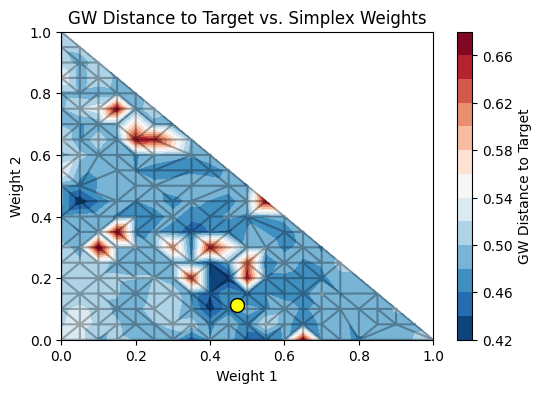

In [5]:
import matplotlib.tri as tri

# Compute analysis of target 
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix, target_measure)

# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
# Add triangulation grid
triang = tri.Triangulation(x_grid_points, y_grid_points)
plt.triplot(triang, color='k', alpha=0.3)
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()

100%|██████████| 21/21 [00:00<00:00, 151.35it/s]


<Figure size 600x400 with 0 Axes>

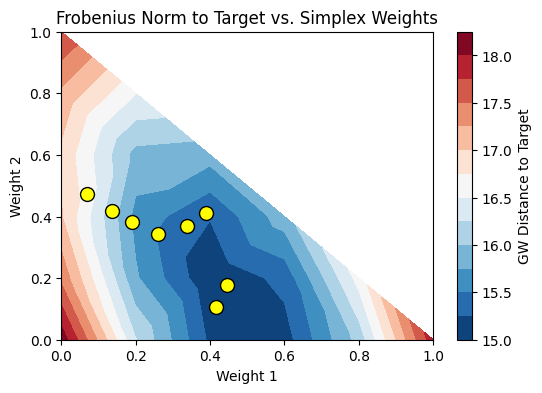

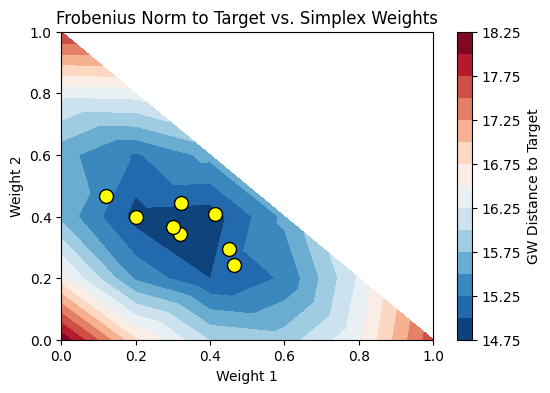

In [6]:
# Iterate over weights in the simplex and compute GW barycenters and their GW distances to the target
target_dist_matrix_permuted = template_dist_matrix.copy()
simplex_grid_points = simplex_grid(N=5)

plt.figure(figsize=(6,4))
for _ in range(2):
    simplex_frobenius_distances_to_permuted_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        simplex_frobenius_distances_to_permuted_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_permuted_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    #triang = tri.Triangulation(x_grid_points, y_grid_points)
    #plt.triplot(triang, color='k', alpha=0.3)

    perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
    target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]

    recovered_lambdas = []
    for _ in range(8):
        _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
        recovered_lambdas.append(lambdas)
        #plt.show()

        perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
        target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]

plt.show()

# True barycenter and permutations heat map 

Analysis method for true barycenters is independent of matrix permutations. 


In [7]:
import signal 

# ----------------------------------------------
# Set up signal handler for timeout with custom exception
# ----------------------------------------------

# Creates a custom exception to be raised by the handler and test in except blocks
class TimeoutException(Exception): 
    pass
# Custom signal handler that is called when the signal is received
def timeout_handler(signum, frame): 
    raise TimeoutException

# Set the signal handler for SIGALRM to our custom handler
signal.signal(signal.SIGALRM, timeout_handler) 

<Handlers.SIG_DFL: 0>

In [8]:
# ----------------------------------------------
# Show that two synthetized barycenters with same weights can be at non-zero GW distance
# ---------------------------------------------- 
lambda_test  = np.array([0.2, 0.3, 0.5])
np.random.seed(42)
target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
np.random.seed(42)
recomputed_target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
dist = ot.gromov.gromov_wasserstein2(
    target_dist_matrix_permuted, 
    recomputed_target_dist_matrix_permuted, 
    ot.unif(target_dist_matrix_permuted.shape[0]), 
    ot.unif(recomputed_target_dist_matrix_permuted.shape[0]), 
    'square_loss'
    )
print(f"GW distance between two barycenters with same weights: {dist}")

# ----------------------------------------------
# Test if two improved synthetized barycenters with same weights can be at non-zero GW distance
# ---------------------------------------------- 
lambda_test  = np.array([0.2, 0.3, 0.5])
target_dist_matrix_permuted = improved_synth(lambda_test,deformed_dist_matrices,deformed_measures)
recomputed_target_dist_matrix_permuted = improved_synth(lambda_test,deformed_dist_matrices,deformed_measures)
dist = np.linalg.norm(target_dist_matrix_permuted-recomputed_target_dist_matrix_permuted,'fro')
# dist = ot.gromov.gromov_wasserstein2(
#     target_dist_matrix_permuted, 
#     recomputed_target_dist_matrix_permuted, 
#     ot.unif(target_dist_matrix_permuted.shape[0]), 
#     ot.unif(recomputed_target_dist_matrix_permuted.shape[0]), 
#     'square_loss'
#     )
print(f"GW distance between two barycenters with same weights: {dist}")


GW distance between two barycenters with same weights: -3.885780586188048e-16
3.6685689923153964e-15
3.383676747769095e-15
GW distance between two barycenters with same weights: 21.1478910697253


100%|██████████| 66/66 [00:30<00:00,  2.17it/s]


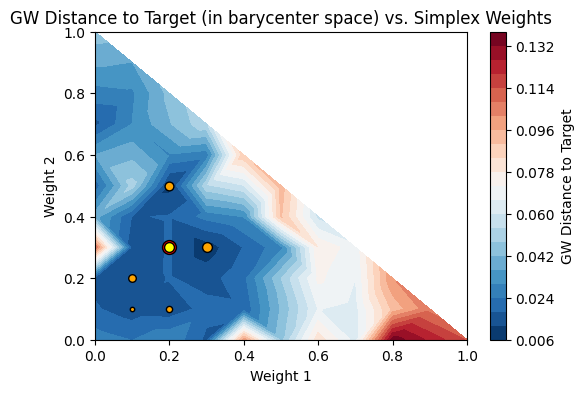

In [9]:
#------------------------------------------------------------
# Plot distances to targets in Frobernius and GW cases when targets are permuted matrices of a real GW barycenter
#------------------------------------------------------------

lambda_test  = np.array([0.2, 0.3, 0.5])
target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
simplex_grid_points = simplex_grid(N=10)

# ------------------------------------------------------------
# Computre GW distances to original target and plot results
# ------------------------------------------------------------
if True: # Disable this block to replot once GW distances are computed
    simplex_GW_distances_to_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        try:
            signal.alarm(3)
            barycenter_dist_matrix = ot.gromov.gromov_barycenters(
                template_dist_matrix.shape[0], 
                Cs = deformed_dist_matrices, 
                lambdas=weights, 
                loss_fun='square_loss'
            )
            gw_dist_to_target = ot.gromov.gromov_wasserstein2(
                barycenter_dist_matrix,
                target_dist_matrix_permuted,
                ot.unif(barycenter_dist_matrix.shape[0]),
                ot.unif(target_dist_matrix.shape[0]),
                'square_loss'
                )
            signal.alarm(0)  # Disable the alarm
            simplex_GW_distances_to_target.append(gw_dist_to_target)
        except TimeoutException:
            simplex_GW_distances_to_target.append(np.nan)


# Clean up NaN values for plotting
z = np.array(simplex_GW_distances_to_target)
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]
min_simplex_grid_points = simplex_grid_points[z.argsort()[:5]]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=24, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target (in barycenter space) vs. Simplex Weights')
# # Plot triangulation grid
# triang = tri.Triangulation(x_grid_points, y_grid_points)
# plt.triplot(triang, color='k', alpha=0.3)
# Plot true and recovered weights
plt.scatter(lambda_test[0], lambda_test[1], color='red', s=100, edgecolor='k', label='Target')
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=50, edgecolor='k', label='Computed Weights our algorithm')
for index, min_point in enumerate(min_simplex_grid_points):
    plt.scatter(min_point[0], min_point[1], color='orange', s=50-10*index, edgecolor='k', label=f'GW Min Weights N {index+1}')
#plt.legend()
plt.show()


100%|██████████| 66/66 [00:00<00:00, 133.59it/s]


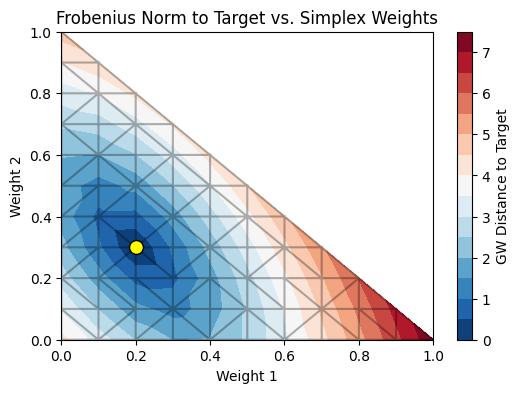

100%|██████████| 66/66 [00:00<00:00, 144.68it/s]


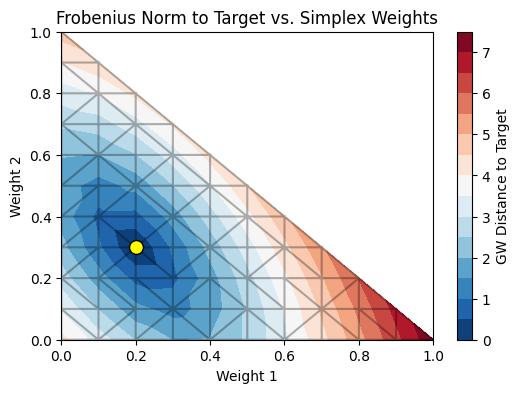

100%|██████████| 66/66 [00:00<00:00, 135.12it/s]


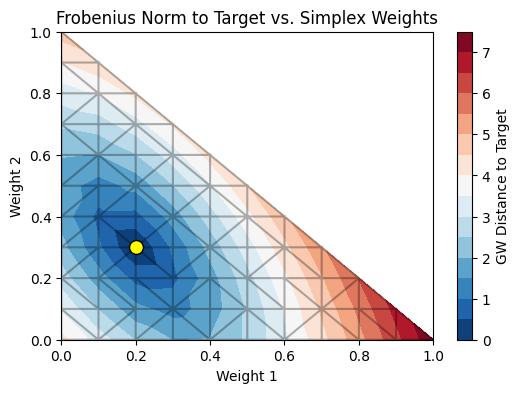

100%|██████████| 66/66 [00:00<00:00, 132.09it/s]


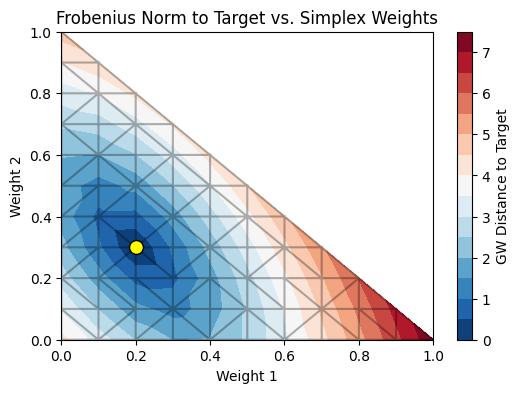

100%|██████████| 66/66 [00:00<00:00, 128.37it/s]


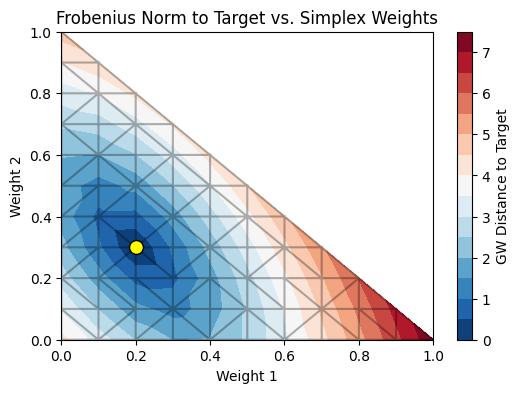

In [10]:
# ------------------------------------------------------------
# Compute Frobenius distances to original and permuted targets and plot results
# ------------------------------------------------------------

# Generate a barycenter to use as target
lambda_test  = np.array([0.2, 0.3, 0.5])
target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
simplex_grid_points = simplex_grid(N=10)


# Compute analysis of target and permuted versions of the target
for _ in range(5):
    simplex_frobenius_distances_to_permuted_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        simplex_frobenius_distances_to_permuted_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_permuted_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    triang = tri.Triangulation(x_grid_points, y_grid_points)
    plt.triplot(triang, color='k', alpha=0.3)
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
    plt.show()

    perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
    target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]

100%|██████████| 66/66 [00:00<00:00, 169.87it/s]


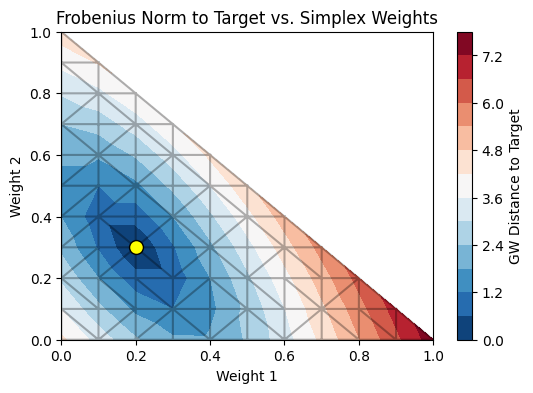

100%|██████████| 66/66 [00:00<00:00, 180.39it/s]


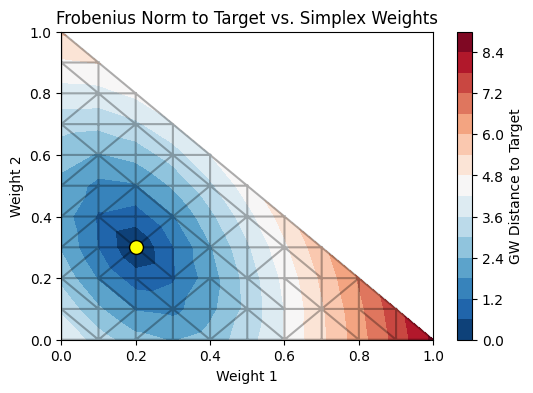

100%|██████████| 66/66 [00:00<00:00, 141.19it/s]


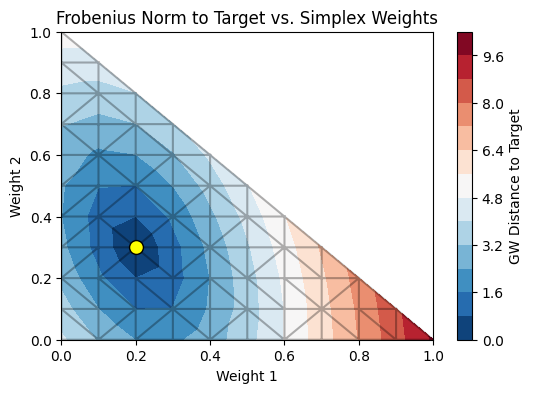

100%|██████████| 66/66 [00:00<00:00, 153.27it/s]


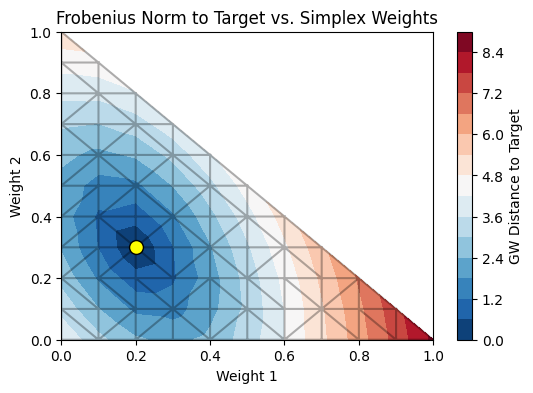

100%|██████████| 66/66 [00:00<00:00, 132.32it/s]


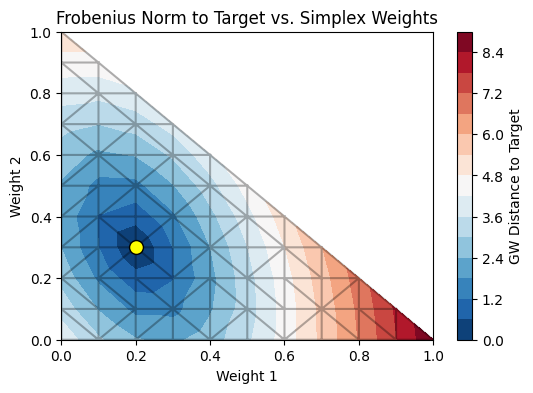

In [11]:
# ------------------------------------------------------------
# Compute Frobenius distances to different sinthetized targets with same weights
# ------------------------------------------------------------

# Generate a barycenter to use as target
lambda_test  = np.array([0.2, 0.3, 0.5])

# Compute analysis of target and permuted versions of the target
for _ in range(5):
    target_dist_synth_matrix = ot.gromov.gromov_barycenters(
        template_dist_matrix.shape[0], 
        Cs = deformed_dist_matrices, 
        lambdas=lambda_test, 
        loss_fun='square_loss'
        )   
    
    simplex_grid_points = simplex_grid(N=10)
    simplex_frobenius_distances_to_synth_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_synth_matrix, ot.unif(target_dist_synth_matrix.shape[0]))
        simplex_frobenius_distances_to_synth_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_synth_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    triang = tri.Triangulation(x_grid_points, y_grid_points)
    plt.triplot(triang, color='k', alpha=0.3)
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_synth_matrix, ot.unif(target_dist_synth_matrix.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
    plt.show()


Real Barycentric Target found


100%|██████████| 66/66 [01:51<00:00,  1.68s/it]
/tmp/ipykernel_28146/838938016.py:87: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(lambda_test[0], lambda_test[1], marker = '+',  color='red', s=500, edgecolor='k', label='Target')


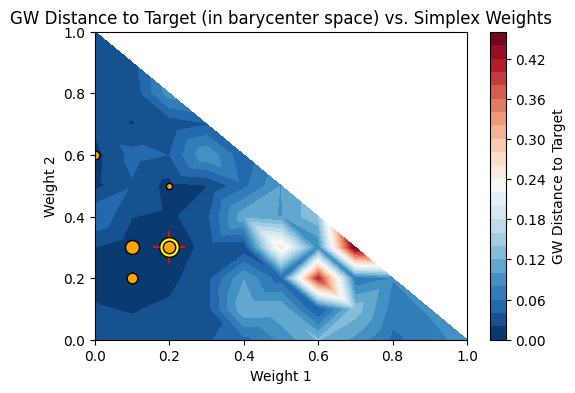

Real Barycentric Target found


100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


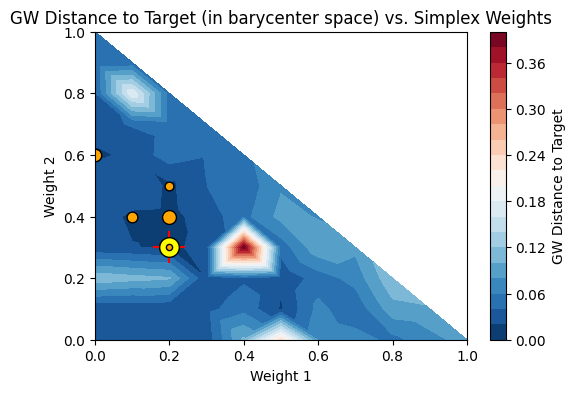

Real Barycentric Target found


100%|██████████| 66/66 [01:22<00:00,  1.25s/it]


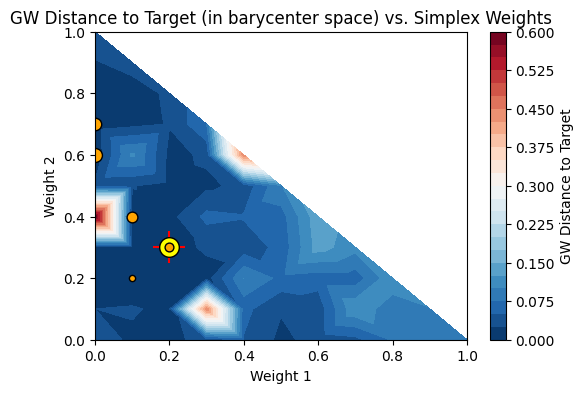

Real Barycentric Target found


 92%|█████████▏| 61/66 [01:12<00:03,  1.32it/s]

In [ ]:
#------------------------------------------------------------
# Plot distances to targets in Frobernius and GW cases when targets are different sythetized matrices of the same lambda weights
#------------------------------------------------------------
import math 

lambda_test  = np.array([0.2, 0.3, 0.5])

for _ in range(5):
    # ------------------------------------------------------------
    # Computre GW distances to original target and plot results
    # ------------------------------------------------------------
    for target_attempt in range(10):
        target_dist_matrix_synth = ot.gromov.gromov_barycenters(
            template_dist_matrix.shape[0], 
            Cs = deformed_dist_matrices, 
            lambdas=lambda_test, 
            loss_fun='square_loss'
            )
        B_blowup, b_blowup, temp_blow_up = utils.blow_up(deformed_dist_matrices, deformed_measures, target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))
        a = utils.get_lambdas_blowup_matrix(temp_blow_up, B_blowup, b_blowup)

        if math.isclose(a, 0.0, rel_tol=1e-12, abs_tol=1e-15):
            print("Real Barycentric Target found")
            break
    
    simplex_grid_points = simplex_grid(N=10)
    simplex_GW_distances_to_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        try:
            for bary_attempt in range(5):
                #print(bary_attempt)
                true_bary = False
                signal.alarm(10)
                barycenter_dist_matrix = ot.gromov.gromov_barycenters(
                    template_dist_matrix.shape[0], 
                    Cs = deformed_dist_matrices, 
                    lambdas=weights, 
                    loss_fun='square_loss'
                )
                signal.alarm(0)  # Disable the alarm
                B_blowup, b_blowup, temp_blow_up = utils.blow_up(deformed_dist_matrices, deformed_measures, barycenter_dist_matrix, ot.unif(barycenter_dist_matrix.shape[0]))
                a = utils.get_lambdas_blowup_matrix(temp_blow_up, B_blowup, b_blowup)

                if math.isclose(a, 0.0, rel_tol=1e-12, abs_tol=1e-15):
                    gw_dist_to_target = ot.gromov.gromov_wasserstein2(
                        barycenter_dist_matrix,
                        target_dist_matrix_synth,
                        ot.unif(barycenter_dist_matrix.shape[0]),
                        ot.unif(target_dist_matrix_synth.shape[0]),
                        'square_loss'
                        )
                    
                    simplex_GW_distances_to_target.append(gw_dist_to_target)
                    true_bary = True
                    #print(f'True bary at {weights}')
                    break
            #print('About to check')    
            if  not true_bary:
                #print(f'Not true bary found at {weights}')
                raise TimeoutException
            
        except TimeoutException:
            simplex_GW_distances_to_target.append(np.nan)
            #print('Added NaN')        


    # Clean up NaN values for plotting
    z = np.array(simplex_GW_distances_to_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]
    min_simplex_grid_points = simplex_grid_points[z.argsort()[:5]]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=24, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('GW Distance to Target (in barycenter space) vs. Simplex Weights')
    # # Plot triangulation grid
    # triang = tri.Triangulation(x_grid_points, y_grid_points)
    # plt.triplot(triang, color='k', alpha=0.3)
    # Plot true and recovered weights
    plt.scatter(lambda_test[0], lambda_test[1], marker = '+',  color='red', s=500, edgecolor='k', label='Target')
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=200, edgecolor='k', label='Computed Weights our algorithm')
    for index, min_point in enumerate(min_simplex_grid_points):
        plt.scatter(min_point[0], min_point[1], color='orange', s=100-20*index, edgecolor='k', label=f'GW Min Weights N {index+1}')
    #plt.legend()
    plt.show()